# 6.6 Sourcing & Analyzing Time-Series Data

### 01. Importing Libraries and Data
### 02. Subsetting, Wrangling, and Cleaning Time-Series Data
### 03. Time Series Analysis: Decomposition
### 04. Testing for Stationarity
### 05. Stationarizing

# 01. Importing Libraries and Data

In [31]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [32]:
quandl.ApiConfig.api_key = 'FU82HejJz5axR2AsvLAw'

In [33]:
data = quandl.get('FRED/GDPPOT')

In [34]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [35]:
data.shape

(332, 1)

In [36]:
data.columns

Index(['Value'], dtype='object')

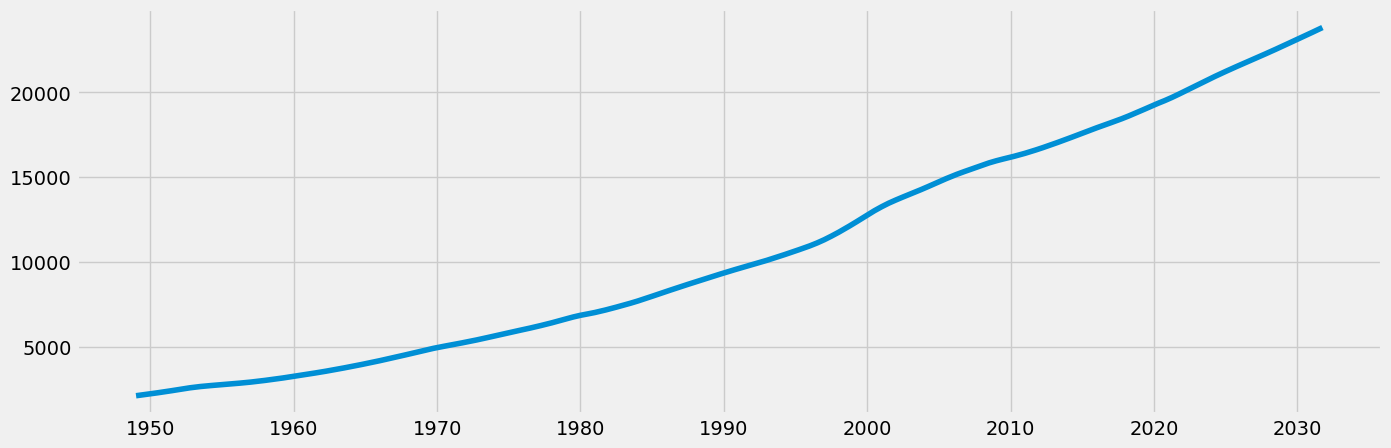

In [37]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

# 02. Subsetting, wrangling, and cleaning time-series data

In [38]:
data_2 = data.reset_index()

In [39]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [40]:
data_sub = data_2.loc[(data_2['Date'] >= '1970-01-01') & (data_2['Date'] <= '2021-07-02')]

1950's and 1960's were not considered for doing time series analysis because I wanted to compose values with from relatively modern to the latest one. An the the latest update date of this data set was 2021-07-02.

In [41]:
data_sub.shape

(207, 2)

In [42]:
data_sub.head()

,Date,Value
84,1970-01-01,4942.234479
85,1970-04-01,4983.442295
86,1970-07-01,5023.272411
87,1970-10-01,5062.162322
88,1971-01-01,5101.081593


In [43]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1970-01-01,4942.234479
1970-04-01,4983.442295
1970-07-01,5023.272411
1970-10-01,5062.162322
1971-01-01,5101.081593


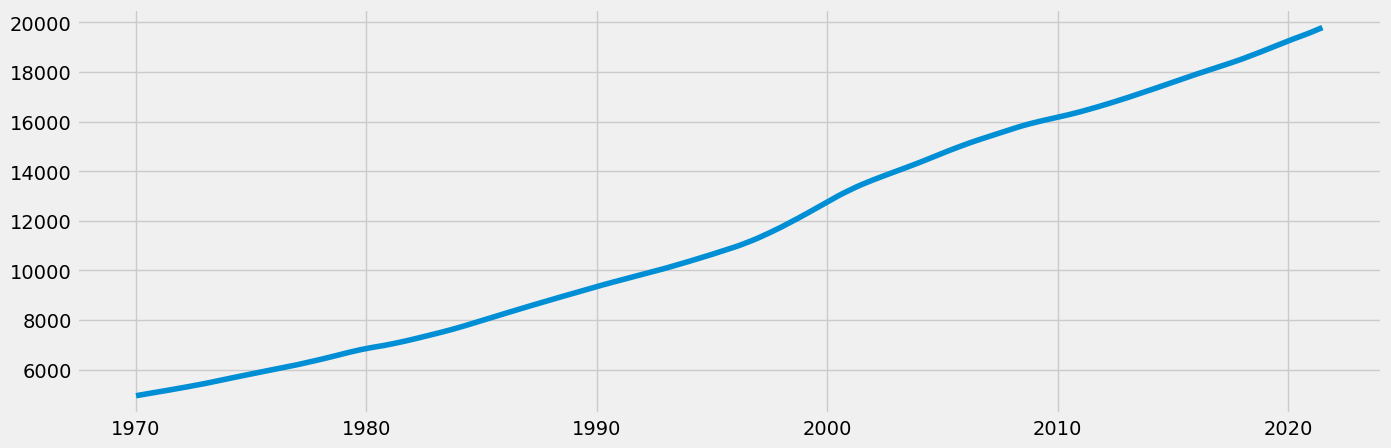

In [44]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [45]:
data_sub.isnull().sum()

Value    0
dtype: int64

In [46]:
dups = data_sub.duplicated()
dups.sum()

0

# 03. Time series analysis: decomposition

In [47]:
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [48]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

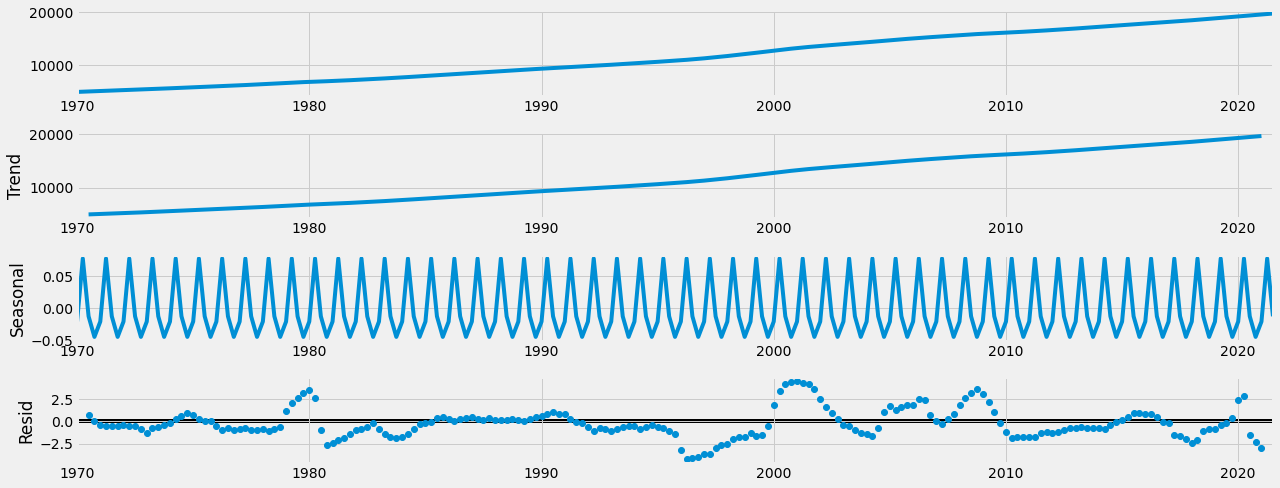

In [49]:
decomposition.plot()
plt.show()

The decomposition represents an upward trend of potential GDP. 

The seasonal plot shows seasonality with keep showing repeated pattern at the same time each year. Every decade has 10 of specific patterns and each of them are considered as a year. Every year, potential GDP gradually drops until June and gradually goes up untill Decenber. Further investigation is needed for revealing the resason of keep repating this pattern. 

Noise were found because of data fluctuations.

# 04. Testing for stationarity

In [50]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.782023
p-value                          0.998313
Number of Lags Used              2.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


The test statistic(1.782023) is larger than the critical value of 5% (-2.875815), and it does mean that it has unit root. The result is not significant because the p-value (0.998313) is bigger than 0.05.

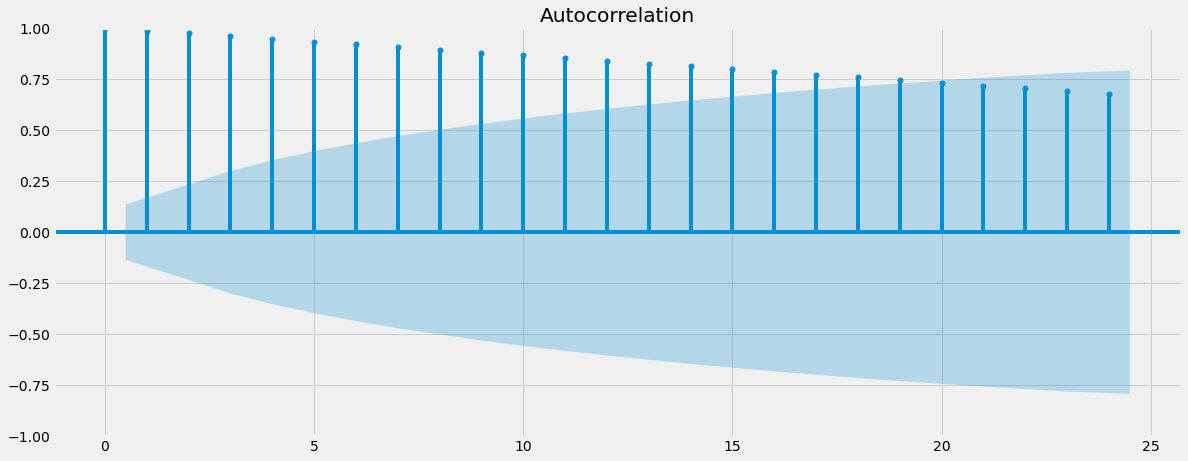

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_sub)
plt.show()

Majority of lags are located out side of confidential interval which means there are lots of autocorrelated data, so  data is non-stationary.

# 05. Stationarizing

In [52]:
data_diff = data_sub - data_sub.shift(1)

In [53]:
data_diff.dropna(inplace = True)

In [54]:
data_diff.head()

,Value
datetime,
1970-04-01,41.207816
1970-07-01,39.830116
1970-10-01,38.889911
1971-01-01,38.919271
1971-04-01,39.689787


In [55]:
data_diff.columns

Index(['Value'], dtype='object')

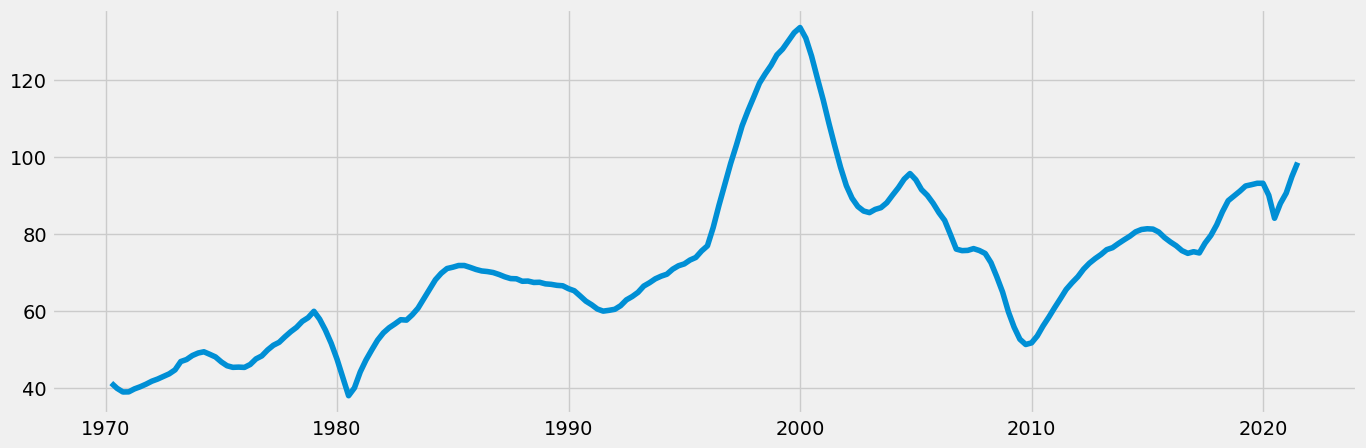

In [56]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [57]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.642683
p-value                          0.084493
Number of Lags Used              1.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


After differencing, test statistics(-2.642683) became smaller thatn critical value of 5%(-2.875815). However, its p-value(0.084493) is still bigger than 0.05.

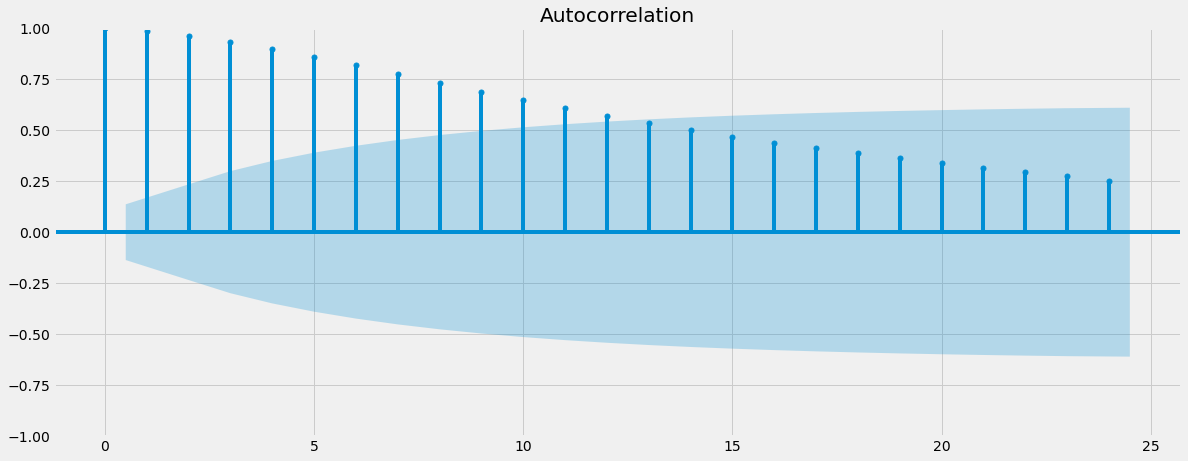

In [58]:
plot_acf(data_diff)
plt.show()

Lots of lags are moved into confidential interval area, but there are still lots of lags that are autocorrelated. It is still is non-stationary.